In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
data = range(1000)

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix-n_steps+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return tensor(X).float(), tensor(y).float()

In [6]:
n_steps = 3
X, y = split_sequence(data,n_steps)

In [7]:
def head(X,y):
    for i in range(5):
        print(X[i], y[i])

In [8]:
head(X,y)

tensor([0., 1., 2.]) tensor([1., 2., 3.])
tensor([1., 2., 3.]) tensor([2., 3., 4.])
tensor([2., 3., 4.]) tensor([3., 4., 5.])
tensor([3., 4., 5.]) tensor([4., 5., 6.])
tensor([4., 5., 6.]) tensor([5., 6., 7.])


In [26]:
bs=12
class Model(nn.Module):
    def __init__(self,n_in, nh, n_out, bs):
        super().__init__()
        self.rnn = nn.RNN(n_in, nh, batch_first=True)  #<--(bs, seq, features)
        self.h_o = nn.Linear(nh,n_out)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(x, self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [27]:
model = Model(1, 50, 1, bs)

In [28]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [29]:
X.shape, y.shape

(torch.Size([997, 3, 1]), torch.Size([997, 3, 1]))

In [30]:
x0 = X[0];
x0 = x0[None,:]; x0.shape

torch.Size([1, 3, 1])

In [31]:
model.rnn(x0)[0].shape

torch.Size([1, 3, 50])

In [32]:
model.bn(model.rnn(x0)[0]).shape

torch.Size([1, 3, 50])

In [33]:
model.h_o(model.bn(model.rnn(x0)[0])).shape

torch.Size([1, 3, 1])

In [38]:
idx = int(0.8*len(X))
ds_train = TensorDataset(X[0:idx],y[0:idx])
ds_valid = TensorDataset(X[idx:],y[idx:])

dl_train = DataLoader(ds_train, bs, drop_last=True)
dl_valid = DataLoader(ds_valid, bs, drop_last=True)

db = fastai.basic_data.DataBunch(dl_train, dl_valid)

learn = fastai.basic_train.Learner(db, 
                                   model, 
                                   loss_func=nn.MSELoss())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


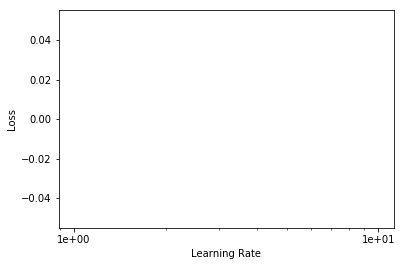

In [39]:
learn.lr_find(); learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,281163.031250,807241.312500,00:00
1,280581.531250,788890.812500,00:00
2,279406.656250,777057.000000,00:00
3,278395.875000,698813.750000,00:00
4,277936.812500,654637.562500,00:00


In [42]:
p,t=learn.get_preds()

In [43]:
p[0], t[0]

(tensor([[57.7272],
         [58.1122],
         [58.8675]]), tensor([[798.],
         [799.],
         [800.]]))